In [1]:
!pip install mrjob

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 439.6/439.6 kB 7.3 MB/s eta 0:00:00


In [2]:
import kagglehub
# Download latest version
path = kagglehub.dataset_download("kieranpoc/steam-reviews")

print("Path to dataset files:", path)
PATH = path

100%|██████████| 16.1G/16.1G [02:51<00:00, 101MB/s] 

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/kieranpoc/steam-reviews/versions/2


In [3]:
PATH = "/root/.cache/kagglehub/datasets/kieranpoc/steam-reviews/versions/2/all_reviews/all_reviews.csv"

In [4]:
%%writefile steam_early_reviews_mrjob.py
from mrjob.job import MRJob
from mrjob.step import MRStep
import csv

EARLY_PERCENTILE = 0.2

class SteamEarlyReviewsMR(MRJob):

    def mapper(self, _, line):
        if line.startswith("recommendationid"):
            return
        try:
            row = next(csv.reader([line]))
            game = row[2]
            playtime = int(row[8])
            voted_up = int(row[14])
            yield game, (playtime, voted_up)
        except:
            pass

    def reducer_collect(self, game, values):
        values = list(values)
        playtimes = sorted(v[0] for v in values)
        if not playtimes:
            return
        cutoff_index = int(len(playtimes) * EARLY_PERCENTILE)
        cutoff = playtimes[cutoff_index]
        for playtime, voted_up in values:
            if playtime <= cutoff:
                yield game, voted_up

    def reducer_aggregate(self, game, votes):
        votes = list(votes)
        total = len(votes)
        positive = sum(votes)
        if total > 0:
            yield game, {
                "total_early_reviews": total,
                "positive_reviews": positive,
                "positive_ratio": positive / total
            }

    def steps(self):
        return [
            MRStep(mapper=self.mapper,
                   reducer=self.reducer_collect),
            MRStep(reducer=self.reducer_aggregate)
        ]

if __name__ == "__main__":
    SteamEarlyReviewsMR.run()

Writing steam_early_reviews_mrjob.py


In [5]:
with open("input_dummy.txt", "w") as f:
    f.write("start")

In [36]:
!head -n 10000000 {PATH} > /content/sample_reviews.csv

In [37]:
!python steam_early_reviews_mrjob.py /content/sample_reviews.csv > mrjob_output.txt

No configs found; falling back on auto-configuration
No configs specified for inline runner
Creating temp directory /tmp/steam_early_reviews_mrjob.root.20251215.125559.488551
Running step 1 of 2...
Running step 2 of 2...
job output is in /tmp/steam_early_reviews_mrjob.root.20251215.125559.488551/output
Streaming final output from /tmp/steam_early_reviews_mrjob.root.20251215.125559.488551/output...
Removing temp directory /tmp/steam_early_reviews_mrjob.root.20251215.125559.488551...


                                     game  total_early_reviews  positive_ratio
0                     "Senren\uff0aBanka"                 3292        0.984812
1                     "People Playground"                43190        0.979972
2                          "A Short Hike"                 2937        0.976847
3                 "Unheard-FirstDLC-FREE"                 1089        0.973370
4                                 "Hades"                47043        0.973003
5                            "Kind Words"                 1697        0.969947
6         "Our Life: Beginnings & Always"                 2027        0.962506
7             "Tales of the Black Forest"                 2156        0.960111
8         "The Henry Stickmin Collection"                 8125        0.959508
9   "Cuphead - The Delicious Last Course"                 4006        0.957064
10                       "Trombone Champ"                 1489        0.950974
11                             "Terraria"           

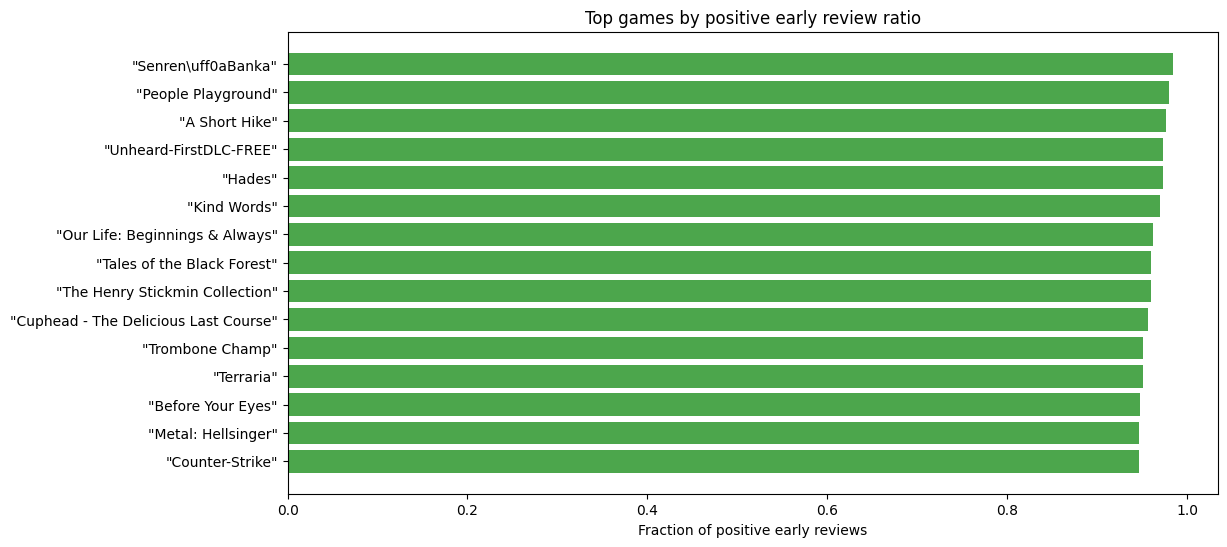

In [38]:
import pandas as pd
import ast
import matplotlib.pyplot as plt

results = []
with open("mrjob_output.txt", "r") as f:
    for line in f:
        if not line.strip():
            continue
        game, stats_str = line.strip().split("\t", 1)
        stats = ast.literal_eval(stats_str)
        results.append((game, stats))

mr_df = pd.DataFrame([
    {
        "game": game,
        "total_early_reviews": stats["total_early_reviews"],
        "positive_reviews": stats["positive_reviews"],
        "positive_ratio": stats["positive_ratio"]
    }
    for game, stats in results
])

filtered_df = mr_df[mr_df["total_early_reviews"] >= 1000]

sorted_df = filtered_df.sort_values(
    by="positive_ratio",
    ascending=False
).reset_index(drop=True)

top_df = sorted_df.head(15)

print(top_df[["game", "total_early_reviews", "positive_ratio"]])

plt.figure(figsize=(12,6))
plt.barh(top_df["game"], top_df["positive_ratio"], color='green', alpha=0.7)
plt.xlabel("Fraction of positive early reviews")
plt.title("Top games by positive early review ratio")
plt.gca().invert_yaxis()
plt.show()


In [9]:
!python --version

Python 3.12.12


In [10]:
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-3.5.0/spark-3.5.0-bin-hadoop3.tgz
!tar xf spark-3.5.0-bin-hadoop3.tgz

!pip install -q findspark

In [11]:
import findspark
findspark.init("/content/spark-3.5.0-bin-hadoop3")

from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("GenderPriceSpark") \
    .master("local[*]") \
    .getOrCreate()

spark

In [39]:
from pyspark.sql.functions import col, when

EARLY_PERCENTILE = 0.2

df = spark.read.csv("sample_reviews.csv", header=True, inferSchema=True)

df = df.select(
    "game",
    col("author_playtime_at_review").cast("double").alias("playtime"),
    col("voted_up").cast("int").alias("voted_up")
)
df = df.withColumn(
    "voted_up",
    when(col("voted_up") == 1, 1)
    .when(col("voted_up") == 0, 0)
    .otherwise(None)
)


In [40]:
from pyspark.sql.functions import expr
percentiles = (
    df
    .groupBy("game")
    .agg(
        expr(f"percentile_approx(playtime, {EARLY_PERCENTILE})").alias("early_threshold")
    )
)

In [41]:
df_with_threshold = df.join(
    percentiles,
    on="game",
    how="inner"
)

early_df = df_with_threshold.filter(
    col("playtime") <= col("early_threshold")
)

In [42]:
from pyspark.sql.functions import count, sum as spark_sum

agg_df = (
    early_df
    .groupBy("game")
    .agg(
        count("*").alias("total_early_reviews"),
        spark_sum("voted_up").alias("positive_reviews")
    )
    .withColumn(
        "positive_ratio",
        col("positive_reviews") / col("total_early_reviews")
    )
)

filtered_df = agg_df.filter(col("total_early_reviews") >= 1000)

In [43]:
top_df = (
    filtered_df
    .orderBy(col("positive_ratio").desc())
    .limit(15)
)

top_pd = top_df.toPandas()
top_pd

,game,total_early_reviews,positive_reviews,positive_ratio
0,Senren＊Banka,3292,3236,0.982989
1,People Playground,43190,42196,0.976985
2,Unheard-FirstDLC-FREE,1089,1056,0.969697
3,Hades,47043,45278,0.962481
4,Tales of the Black Forest,2156,2066,0.958256
5,The Henry Stickmin Collection,8125,7714,0.949415
6,Terraria,241234,228391,0.946761
7,A Short Hike,2937,2774,0.944501
8,The Rewinder,1172,1104,0.941980
9,Counter-Strike,45254,42540,0.940027


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 65290 (\N{FULLWIDTH ASTERISK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


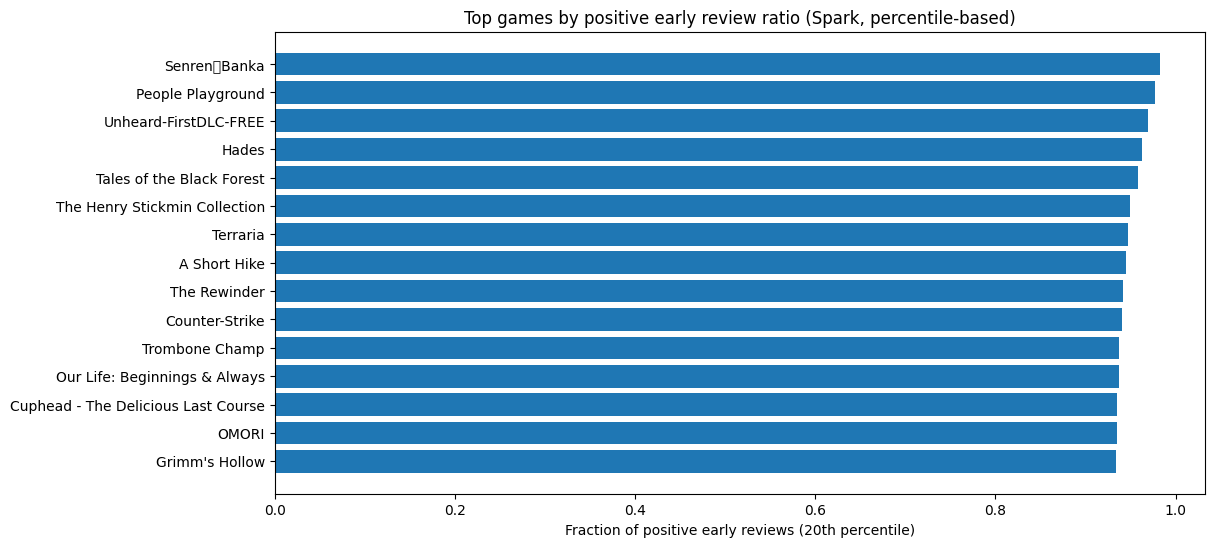

In [44]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.barh(top_pd["game"], top_pd["positive_ratio"])
plt.xlabel("Fraction of positive early reviews (20th percentile)")
plt.title("Top games by positive early review ratio (Spark, percentile-based)")
plt.gca().invert_yaxis()
plt.show()

In [18]:
!pip install luigi


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 17.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for luigi: filename=luigi-3.6.0-py3-none-any.whl size=1093756 sha256=10bebe9ab61f8370ffa91535622bdf6cee4466b7efe643c6d27d9a3779efce91
  Stored in directory: /root/.cache/pip/wheels/6b/67/54/c530d79c6eb27962863fe9f4d1612951ae346f7a6f541259f9
Successfully built luigi
  Attempting uninstall: tenacity
    Found existing installation: tenacity 9.1.2
    Uninstalling tenacity-9.1.2:
      Successfully uninstalled tenacity-9.1.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-adk 1.20.0 requires tenacity<10.0.0,>=9.0.0, but you have tenacity 8.5.0 which is incompatible.


In [45]:
%%writefile spark_analysis.py

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, count, sum as spark_sum, expr

PATH = "/content/sample_reviews.csv"
EARLY_PERCENTILE = 0.2
OUTPUT = "spark_result.csv"

spark = SparkSession.builder \
    .appName("SteamEarlyReviews") \
    .master("local[*]") \
    .getOrCreate()

df = spark.read.csv(PATH, header=True, inferSchema=True)

df = df.select(
    "game",
    col("author_playtime_at_review").cast("double").alias("playtime"),
    col("voted_up").cast("int").alias("voted_up")
)

df = df.withColumn(
    "voted_up_clean",
    when(col("voted_up") == 1, 1)
    .when(col("voted_up") == 0, 0)
    .otherwise(None)
).filter(col("voted_up_clean").isNotNull())

percentiles = (
    df.groupBy("game")
      .agg(expr(f"percentile_approx(playtime, {EARLY_PERCENTILE})").alias("early_threshold"))
)

early = df.join(percentiles, "game") \
          .filter(col("playtime") <= col("early_threshold"))

result = (
    early.groupBy("game")
         .agg(
             count("*").alias("total_reviews"),
             spark_sum("voted_up_clean").alias("positive_reviews")
         )
         .filter(col("total_reviews") >= 1000)
         .withColumn(
             "positive_ratio",
             col("positive_reviews") / col("total_reviews")
         )
)

result.toPandas().to_csv(OUTPUT, index=False)

spark.stop()


Overwriting spark_analysis.py


In [46]:
!/content/spark-3.5.0-bin-hadoop3/bin/spark-submit spark_analysis.py

25/12/15 13:06:33 INFO SparkContext: Running Spark version 3.5.0
25/12/15 13:06:33 INFO SparkContext: OS info Linux, 6.6.105+, amd64
25/12/15 13:06:33 INFO SparkContext: Java version 17.0.17
25/12/15 13:06:33 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/12/15 13:06:34 INFO ResourceUtils: ==============================================================
25/12/15 13:06:34 INFO ResourceUtils: No custom resources configured for spark.driver.
25/12/15 13:06:34 INFO ResourceUtils: ==============================================================
25/12/15 13:06:34 INFO SparkContext: Submitted application: SteamEarlyReviews
25/12/15 13:06:34 INFO ResourceProfile: Default ResourceProfile created, executor resources: Map(cores -> name: cores, amount: 1, script: , vendor: , memory -> name: memory, amount: 1024, script: , vendor: , offHeap -> name: offHeap, amount: 0, script: , vendor: ), task resources: Map(cpus -> name:

In [47]:
%%writefile steam_dag.py

import luigi
import subprocess
import os

SPARK_SUBMIT = "/content/spark-3.5.0-bin-hadoop3/bin/spark-submit"

class RunSparkAnalysis(luigi.Task):

    def output(self):
        return luigi.LocalTarget("spark_result.csv")

    def run(self):
        subprocess.run(
            [SPARK_SUBMIT, "spark_analysis.py"],
            check=True
        )


Overwriting steam_dag.py


In [48]:
!python -m luigi \
  --module steam_dag \
  RunSparkAnalysis \
  --local-scheduler

DEBUG: Checking if RunSparkAnalysis() is complete
INFO: Informed scheduler that task   RunSparkAnalysis__99914b932b   has status   DONE
INFO: Done scheduling tasks
INFO: Running Worker with 1 processes
DEBUG: Asking scheduler for work...
DEBUG: Done
DEBUG: There are no more tasks to run at this time
INFO: Worker Worker(salt=9893929800, workers=1, host=e1e082ff94d2, username=root, pid=22680) was stopped. Shutting down Keep-Alive thread
INFO: 
===== Luigi Execution Summary =====

Scheduled 1 tasks of which:
* 1 complete ones were encountered:
    - 1 RunSparkAnalysis()

Did not run any tasks
This progress looks :) because there were no failed tasks or missing dependencies

===== Luigi Execution Summary =====



In [49]:
!python -m luigi --module steam_dag RunSparkAnalysis --local-scheduler


DEBUG: Checking if RunSparkAnalysis() is complete
INFO: Informed scheduler that task   RunSparkAnalysis__99914b932b   has status   DONE
INFO: Done scheduling tasks
INFO: Running Worker with 1 processes
DEBUG: Asking scheduler for work...
DEBUG: Done
DEBUG: There are no more tasks to run at this time
INFO: Worker Worker(salt=6812599872, workers=1, host=e1e082ff94d2, username=root, pid=22700) was stopped. Shutting down Keep-Alive thread
INFO: 
===== Luigi Execution Summary =====

Scheduled 1 tasks of which:
* 1 complete ones were encountered:
    - 1 RunSparkAnalysis()

Did not run any tasks
This progress looks :) because there were no failed tasks or missing dependencies

===== Luigi Execution Summary =====

